In [2]:
!pip install ipycanvas
!pip install ipywidgets
!pip install plotly
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.9 MB/s eta 0:00:00


In [3]:
# -----------------------------
# Cell 1: Imports
# -----------------------------
from ipycanvas import Canvas
from ipywidgets import VBox, HBox, Button, FloatText, Dropdown, interact, FloatSlider
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import pickle
from mpl_toolkits.mplot3d import Axes3D
from ipycanvas import Canvas
from ipywidgets import VBox, HBox, Button, FloatText, Dropdown
import numpy as np
# Function to sample from this density
from scipy.interpolate import interp1d



In [4]:

class Sketulate:
    def __init__(self, width=200, height=200):
        self.width, self.height = width, height
        self.canvas = Canvas(width=width, height=height, background_color="white")
        self.canvas.layout.width = "200px"
        self.canvas.layout.height = "200px"
        self.points = []
        self.drawing = False

        # buttons
        self.clear_btn = Button(description="Clear")
        self.finish_btn = Button(description="Finish")
        self.accept_btn = Button(description="Accept", disabled=True)
        self.update_btn = Button(description="Update Range")

        # ranges
        self.x_min = FloatText(description="x min", value=0.0, layout={"width":"150px"})
        self.x_max = FloatText(description="x max", value=1.0, layout={"width":"150px"})
        self.y_min = FloatText(description="y min", value=0.0, layout={"width":"150px"})
        self.y_max = FloatText(description="y max", value=1.0, layout={"width":"150px"})

        # mode
        self.mode = Dropdown(description="Mode", options=["function", "density"], value="function")

        # bind canvas events
        self.canvas.on_mouse_down(self._start_drawing)
        self.canvas.on_mouse_up(self._stop_drawing)
        self.canvas.on_mouse_move(self._record_point)

        # bind buttons
        self.clear_btn.on_click(self.clear_canvas)
        self.finish_btn.on_click(self.finish_drawing)
        self.update_btn.on_click(self._draw_grid)

        # internal callback
        self.accept_callback = None
        self.accept_btn.on_click(self._on_accept)

        # draw first grid
        self._draw_grid()

        self.x = None
        self.y = None
        self.f = None
        self.g = None


    # ---------------- Drawing ----------------
    def _draw_grid(self, b=None):
        self.canvas.clear()

        # grid lines
        step = self.width // 10
        self.canvas.stroke_style = "#e0e0e0"
        for i in range(0, self.width+1, step):
            self.canvas.stroke_line(i, 0, i, self.height)
        for j in range(0, self.height+1, step):
            self.canvas.stroke_line(0, j, self.width, j)

        # redraw points
        self.canvas.fill_style = "black"
        for x, y in self.points:
            self.canvas.fill_circle(x, y, 2)

    def _start_drawing(self, x, y):
        self.drawing = True
        self.points.append((x, y))
        self.canvas.fill_style = "black"
        self.canvas.fill_circle(x, y, 2)

    def _stop_drawing(self, x, y):
        self.drawing = False

    def _record_point(self, x, y):
        if self.drawing:
            self.points.append((x, y))
            self.canvas.fill_style = "black"
            self.canvas.fill_circle(x, y, 2)

    # ---------------- Controls ----------------
    def clear_canvas(self, b=None):
        self.points = []
        self._draw_grid()
        self.accept_btn.disabled = True
        self.finish_btn.disabled = False

    def finish_drawing(self, b=None):
        if not self.points:
            print("Draw something first!")
            return
        self.accept_btn.disabled = False
        self.finish_btn.disabled = True
        print("Drawing finished, press Accept.")

    def accept(self, callback):
        """Set function to call when Accept is pressed"""
        self.accept_callback = callback

    def _on_accept(self, b=None):
        if self.accept_callback and self.points:
            xs, ys = self.get_points()
            self.accept_callback(self.mode.value, (xs, ys))
        self.accept_btn.disabled = True
        print("accept callback")
        self.get_points()
        print(self.mode.value)
        if self.mode.value == 'function':
          self.fit_piecewise_linear()
        elif self.mode.value == 'density':
          self.fit_density()

    def get_points(self):
        """Return scaled xs, ys according to user ranges"""
        if not self.points:
            raise ValueError("No points drawn yet!")
        xs, ys = zip(*self.points)
        xs = np.array(xs)
        ys = np.array(ys)

        # scale to axis ranges
        xs = (xs / self.width) * (self.x_max.value - self.x_min.value) + self.x_min.value
        ys = ((self.height - ys) / self.height) * (self.y_max.value - self.y_min.value) + self.y_min.value

        self.x = xs
        self.y = ys

    def fit_piecewise_linear(self, n_knots=20):
      sort_idx = np.argsort(self.x)
      xs_sorted, ys_sorted = self.x[sort_idx], self.y[sort_idx]
      n_knots = min(len(xs_sorted), n_knots)
      model = make_pipeline(
          SplineTransformer(n_knots=n_knots, degree=1),
          LinearRegression()
      )
      model.fit(xs_sorted.reshape(-1,1), ys_sorted)
      self.f = model

    def fit_density(self):
      # Ensure the density is non-negative
      ys_d = np.maximum(self.y, 0)

      # Normalize to integrate to 1
      area = np.trapezoid(ys_d, self.x)
      self.y_norm = ys_d / area

      # Interpolated density for sampling
      density_func = interp1d(self.x, self.y_norm, kind='linear', bounds_error=False, fill_value=0.0)

      def sample_from_density(n=1000):
          # Rejection sampling
          x_min, x_max = self.x.min(), self.x.max()
          y_max = self.y_norm.max()
          samples = []
          while len(samples) < n:
              x_trial = np.random.uniform(x_min, x_max)
              y_trial = np.random.uniform(0, y_max)
              if y_trial < density_func(x_trial):
                  samples.append(x_trial)
          return np.array(samples)

      self.g = sample_from_density


    # ---------------- UI ----------------
    def sketch(self):
        return VBox([
            self.canvas,
            HBox([self.clear_btn, self.finish_btn, self.accept_btn, self.mode]),
            HBox([self.x_min, self.x_max, self.y_min, self.y_max, self.update_btn])
        ])


In [7]:
from google.colab import output
output.enable_custom_widget_manager()

In [190]:
#sketch f1(x)
f1 = Sketulate()
f1.sketch()



Drawing finished, press Accept.
accept callback
function


In [192]:
# Sketch f2(y)
f2 = Sketulate()
f2.sketch()




Drawing finished, press Accept.
accept callback
function


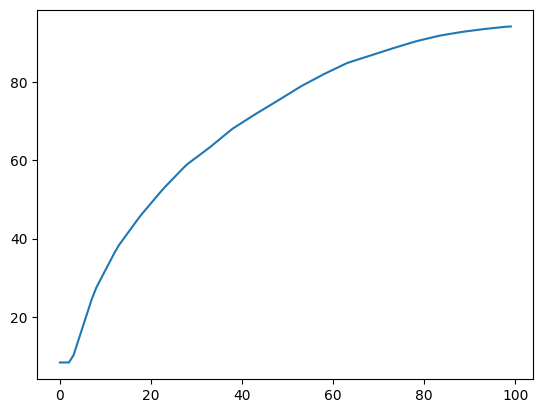

In [197]:
plt.plot(f1.f.predict(np.linspace(0,25,100).reshape(-1,1)))

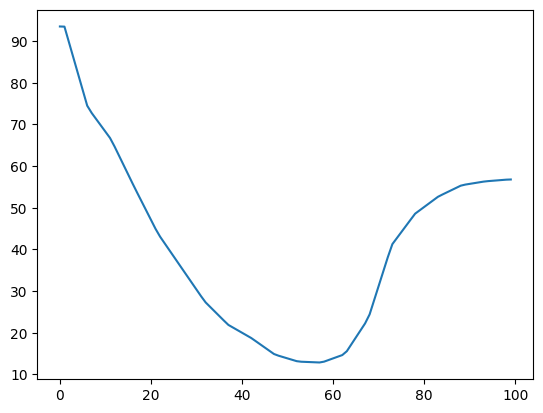

In [196]:
plt.plot(f2.f.predict(np.linspace(0,45,100).reshape(-1,1)))

## Density Version

In [176]:
# Create a new canvas in density mode
x = Sketulate()
display(x.sketch())


Drawing finished, press Accept.
accept callback
density


(array([89., 15., 57., 84., 82., 93., 67., 83., 68., 52., 42., 28., 34.,
        22., 36., 33., 30., 26., 32., 27.]),
 array([0.15750713, 0.64600927, 1.1345114 , 1.62301353, 2.11151567,
        2.6000178 , 3.08851994, 3.57702207, 4.0655242 , 4.55402634,
        5.04252847, 5.5310306 , 6.01953274, 6.50803487, 6.996537  ,
        7.48503914, 7.97354127, 8.46204341, 8.95054554, 9.43904767,
        9.92754981]),
 <BarContainer object of 20 artists>)

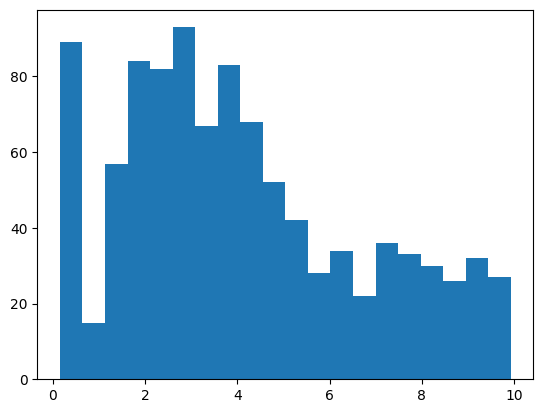

In [181]:
plt.hist(x.g(1000), bins=20)

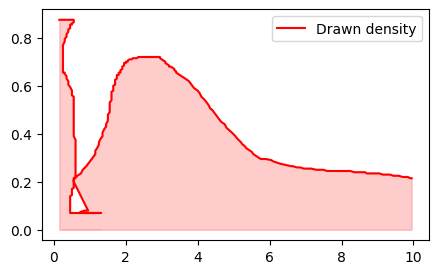

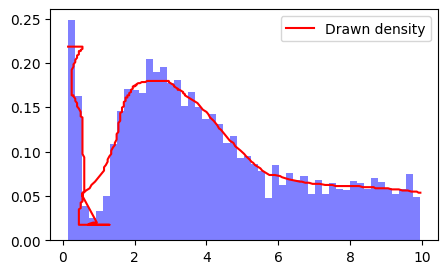

In [179]:
# Plot the drawn density
plt.figure(figsize=(5,3))
plt.plot(x.x, x.y, 'r-', label='Drawn density')
plt.fill_between(x.x, 0, x.y, color='r', alpha=0.2)
plt.legend()
plt.show()

# Sample from density and plot histogram
samples = x.g(5000)
plt.figure(figsize=(5,3))
plt.hist(samples, bins=50, density=True, alpha=0.5, color='blue')
plt.plot(x.x, x.y_norm, 'r-', label='Drawn density')
plt.legend()
plt.show()


In [189]:
y = Sketulate()
y.sketch()

Drawing finished, press Accept.
accept callback
density


## Interaction Terms


In [198]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, HBox, VBox, Layout, Button
from IPython.display import display, clear_output
from scipy.interpolate import LinearNDInterpolator

class SketulateInteraction:
    def __init__(self, x_range=(-5,5), y_range=(-5,5), z_range=(-5,5), grid_size=5):
        self.grid_size = grid_size
        self.x_range = x_range
        self.y_range = y_range
        self.z_range = z_range

        # Meshgrid
        self.X, self.Y = np.meshgrid(np.linspace(*x_range, grid_size),
                                     np.linspace(*y_range, grid_size))
        self.Z = np.zeros_like(self.X)

        # Sliders
        self.sliders = []
        self.slider_layout = Layout(width="80px", height="20px")
        self.rows = []

        for i in range(grid_size):
            row_sliders = [self._make_slider(i, j) for j in range(grid_size)]
            self.sliders.extend(row_sliders)
            self.rows.append(HBox(row_sliders))

        # Accept button
        self.accept_btn = Button(description="Accept", button_style="success")
        self.accept_btn.on_click(self._on_accept)

        self.ui = VBox(self.rows + [self.accept_btn])

        # Storage
        self.x = None
        self.y = None
        self.z = None
        self.f = None  # interpolator inside convex hull
        self.linear_plane = None  # coefficients for linear extrapolation

    # ---------------- Sliders ----------------
    def _make_slider(self, i, j):
        slider = FloatSlider(
            value=0,
            min=self.z_range[0],
            max=self.z_range[1],
            step=0.1,
            description="",
            continuous_update=False,
            readout=False,
            layout=self.slider_layout
        )
        def update(change):
            self.Z[i, j] = slider.value
            self._plot_surface()
        slider.observe(update, names="value")
        return slider

    # ---------------- Plotting ----------------
    def _plot_surface(self):
        clear_output(wait=True)
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.X, self.Y, self.Z, cmap="viridis")
        ax.set_zlim(*self.z_range)
        plt.show()
        display(self.ui)

    # ---------------- Accept ----------------
    def _on_accept(self, b):
        self.x = self.X.flatten()
        self.y = self.Y.flatten()
        self.z = self.Z.flatten()

        points = np.column_stack([self.x, self.y])
        self.f = LinearNDInterpolator(points, self.z, fill_value=np.nan)

        # Fit plane for linear extrapolation: z = a*x + b*y + c
        A = np.column_stack([self.x, self.y, np.ones_like(self.x)])
        self.linear_plane, _, _, _ = np.linalg.lstsq(A, self.z, rcond=None)

        print("✅ Surface accepted. ND linear interpolator with linear extrapolation ready.")

    # ---------------- Prediction ----------------
    def predict(self, x_new, y_new):
        x_new = np.array(x_new)
        y_new = np.array(y_new)
        points_new = np.column_stack([x_new, y_new])
        z_pred = self.f(points_new)

        # Identify NaNs (outside convex hull) and replace with plane
        nan_mask = np.isnan(z_pred)
        if np.any(nan_mask):
            a, b, c = self.linear_plane
            z_pred[nan_mask] = a*x_new[nan_mask] + b*y_new[nan_mask] + c
        return z_pred

    # ---------------- Visualize ----------------
    def plot_fitted_surface(self, n_points=50):
        x_fine = np.linspace(*self.x_range, n_points)
        y_fine = np.linspace(*self.y_range, n_points)
        X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
        Z_fine = self.predict(X_fine.flatten(), Y_fine.flatten()).reshape(X_fine.shape)

        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X_fine, Y_fine, Z_fine, cmap="viridis")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_xlim(*self.x_range)
        ax.set_ylim(*self.y_range)
        ax.set_zlim(*self.z_range)
        plt.show()

    # ---------------- Public ----------------
    def sketch(self):
        self._plot_surface()


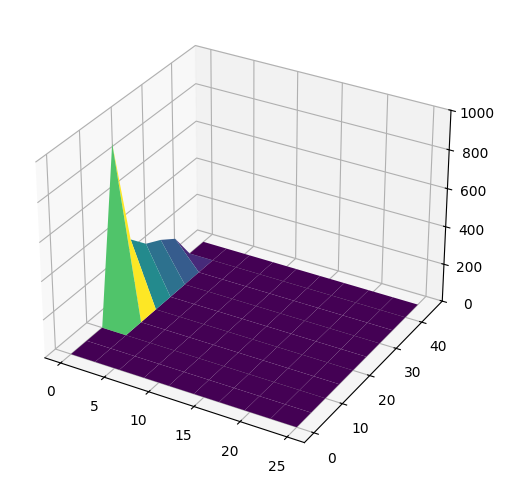

✅ Surface accepted. ND linear interpolator with linear extrapolation ready.


In [259]:
sk = SketulateInteraction(
    x_range=(0,25),
    y_range=(0,45),
    z_range=(0,1000),
    grid_size=10
)

sk.sketch()

In [260]:
print(sk.x)  # flattened X coordinates
print(sk.y)  # flattened Y coordinates
print(sk.z)

[ 0.          2.77777778  5.55555556  8.33333333 11.11111111 13.88888889
 16.66666667 19.44444444 22.22222222 25.          0.          2.77777778
  5.55555556  8.33333333 11.11111111 13.88888889 16.66666667 19.44444444
 22.22222222 25.          0.          2.77777778  5.55555556  8.33333333
 11.11111111 13.88888889 16.66666667 19.44444444 22.22222222 25.
  0.          2.77777778  5.55555556  8.33333333 11.11111111 13.88888889
 16.66666667 19.44444444 22.22222222 25.          0.          2.77777778
  5.55555556  8.33333333 11.11111111 13.88888889 16.66666667 19.44444444
 22.22222222 25.          0.          2.77777778  5.55555556  8.33333333
 11.11111111 13.88888889 16.66666667 19.44444444 22.22222222 25.
  0.          2.77777778  5.55555556  8.33333333 11.11111111 13.88888889
 16.66666667 19.44444444 22.22222222 25.          0.          2.77777778
  5.55555556  8.33333333 11.11111111 13.88888889 16.66666667 19.44444444
 22.22222222 25.          0.          2.77777778  5.55555556  8.333

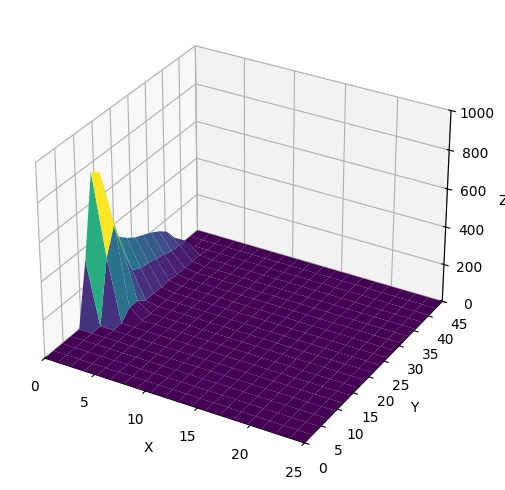

In [261]:
sk.plot_fitted_surface(n_points=20)

In [262]:
sk.predict([5],[0])

array([0.])

### Reproducible Example

In [263]:
# Start by creating the simulated input data for x and y

# Draw 1000 samples for x
x_sample = x.g(1000)
y_sample = y.g(1000)

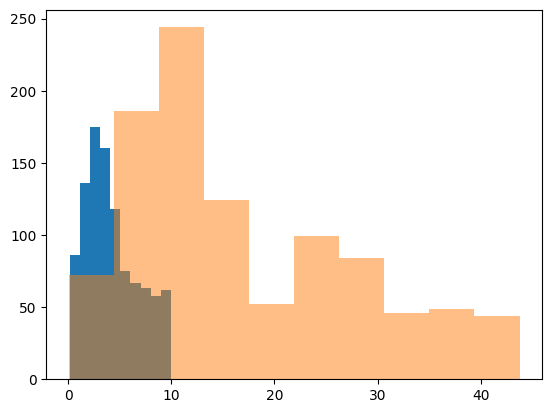

In [264]:
plt.hist(x_sample)
plt.hist(y_sample, alpha=0.5)
plt.show()

In [266]:
z = f1.f.predict(x_sample.reshape(-1,1)) + f2.f.predict(y_sample.reshape(-1,1)) + sk.predict(x_sample, y_sample)

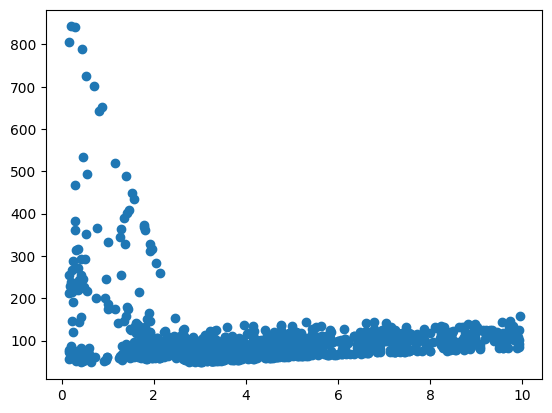

In [267]:
plt.scatter(x_sample, z)

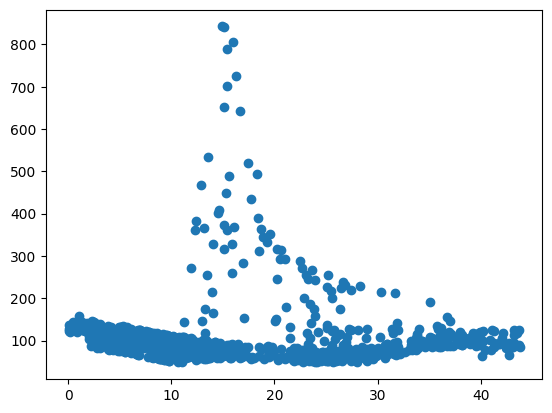

In [268]:
plt.scatter(y_sample, z)

In [257]:
!pip install plotly

In [269]:
import numpy as np
import plotly.graph_objects as go

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_sample,
    y=y_sample,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,           # color by z-value
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="Interactive 3D Scatter Plot"
)

# Show plot (rotatable, zoomable, pan)
fig.show()
